## Hyperparameter Selection

In the first part of our lab, we will explore two methods for hyperparameter tuning a machine learning model.

In contrast to model parameters which are learned during training, model hyperparameters are set by the data scientist ahead of training. The weights learned during training are parameters while the number of trees in a random forest is a model hyperparameter because this is set by the data scientist. Hyperparameters can be thought of as model settings. These settings need to be tuned for each problem because the best model hyperparameters for one particular dataset will not be the best across all datasets. The process of hyperparameter tuning (also called hyperparameter optimization) means finding the best combination of hyperparameter values for a machine learning model - as measured on a validation set.

There are several approaches to hyperparameter tuning

    1. Manual: Select hyperparameters based on intuition/experience/guessing, train the model with the hyperparameters, and score on the validation data. Repeat this process until you are satisfied with the results.
    2. Grid Search: Set up a grid of hyperparameter values and for each combination, train a model and score on the validation data. In this approach, every single combination of hyperparameter values is tried which can be very inefficient.
    3. Random search: Set up a grid of hyperparameter values and select random combinations to train the model and score. The number of search iterations is set based on time/resources.
    4. Automated Hyperparameter Tuning: Use methods such as gradient descent, Bayesian optimization, or evolutionary algorithms to conduct a guided search for the best combination.

In this lab, we will implement approaches 2 and 3 for a Gradient Boosting model.

### Getting Started

We will work with a subset of the data consisting of 10000 rows. Hyperparameter tuning is extremely computationally expensive and working with the full dataset would not be feasible for more than a few search iterations. However, the same ideas that we will implement here can be applied to the full dataset and while this notebook is specifically aimed at the GBM, the methods can be applied for any machine learning model.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb
import logging
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)

# Splitting data
from sklearn.model_selection import train_test_split

N_FOLDS = 5
MAX_EVALS = 5

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Below we read in the data and separate it into a training set of 10000 observations and a "testing set" of 6000 observations. After creating the testing set, we cannot do any hyperparameter tuning with it.

In [2]:
features = pd.read_csv('/content/data.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 50)

In [3]:
print("Training features shape: ", train_features.shape)
print("Testing features shape: ", test_features.shape)

Training features shape:  (10000, 104)
Testing features shape:  (6000, 104)


In [4]:
# Create a training and testing dataset
train_set = lgb.Dataset(data = train_features, label = train_labels, free_raw_data=False)
test_set = lgb.Dataset(data = test_features, label = test_labels, free_raw_data=False)

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Import the early_stopping callback
from lightgbm import early_stopping

# Get default hyperparameters
model = lgb.LGBMClassifier()
default_params = model.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']

# Cross validation with early stopping using the callback
cv_results = lgb.cv(default_params, train_set, num_boost_round=10000,
                    metrics='auc', nfold=N_FOLDS, seed=42,
                    callbacks=[early_stopping(stopping_rounds=100)]) # Use early_stopping callback

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9997
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.355919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9997
[LightGBM] [Info] Number of data points in the train

In [7]:
print(cv_results)

{'valid auc-mean': [0.6606296820006892, 0.6785737247461092, 0.6876787764186905, 0.6920238536470323, 0.6980282114062015, 0.7007515262272621, 0.7019102402720371, 0.7027799296244843, 0.7038111174147241, 0.7052532594510132, 0.708413098254373, 0.709269070051753, 0.7103137324993294, 0.7106799939939954, 0.7119391930339403, 0.7127252039141159, 0.7144109391747674, 0.7153335805912058, 0.7163621210120483], 'valid auc-stdv': [0.03433995447791942, 0.03923359090275524, 0.034770677423619036, 0.031282692518835725, 0.030364861014553008, 0.032530870027039395, 0.03328890054084283, 0.02812952014701759, 0.02805930888843699, 0.026281552709974957, 0.02366788251994557, 0.022034769091263413, 0.023137377203538416, 0.020539797269945013, 0.02089219775313339, 0.01925231985647043, 0.017883261073009915, 0.017829703218800005, 0.018142016766178933]}


In [8]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['valid auc-mean'][-1], cv_results['valid auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['valid auc-mean'])))

The maximum validation ROC AUC was: 0.71636 with a standard deviation of 0.01814.
The optimal number of boosting rounds (estimators) was 19.


We can use this result as a baseline model to beat. To find out how well the model does on our "test" data, we will retrain it on all the training data with the best number of estimators found during cross validation with early stopping.

In [9]:
from sklearn.metrics import roc_auc_score

In [10]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['valid auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

[LightGBM] [Info] Number of positive: 824, number of negative: 9176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9997
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082400 -> initscore=-2.410176
[LightGBM] [Info] Start training from score -2.410176
The baseline model scores 0.71370 ROC AUC on the test set.


This is the baseline score before hyperparameter tuning. The only difference we made from the default model was using early stopping to set the number of estimators (which by default is 100).

### Hyperparameter Tuning Implementation

Now we have the basic framework in place, we will use cross validation to determine the performance of model hyperparameters and early stopping with the GBM so we do not have to tune the number of estimators. The basic strategy for both grid and random search is simple: for each hyperparameter value combination, evaluate the cross validation score and record the results along with the hyperparameters. Then, at the end of searching, choose the hyperparameters that yielded the highest cross-validation score, train the model on all the training data, and make predictions on the test data.

It's helpful to think of hyperparameter tuning as having four parts:

    1. Objective function: a function that takes in hyperparameters and returns a score we are trying to minimize or maximize
    2. Domain: the set of hyperparameter values over which we want to search.
    3. Algorithm: method for selecting the next set of hyperparameters to evaluate in the objective function.
    4. Results history: data structure containing each set of hyperparameters and the resulting score from the objective function.

### Objective Function

In [11]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""

    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']

    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round=10000,
                    metrics='auc', nfold=N_FOLDS, seed=42,
                    callbacks=[early_stopping(stopping_rounds=100)])

    # results to retun
    score = cv_results['valid auc-mean'][-1]
    estimators = len(cv_results['valid auc-mean'])
    hyperparameters['n_estimators'] = estimators

    return [score, hyperparameters, iteration]

In [12]:
score, params, iteration = objective(default_params, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9997
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9997
[LightGBM] [Info] Number of data points in the train set: 80

### Domain

The domain, or search space, is all the possible values for all the hyperparameters that we want to search over. For random and grid search, the domain is a hyperparameter grid and usually takes the form of a dictionary with the keys being the hyperparameters and the values lists of values for each hyperparameter.

In [13]:
# Create a default model
model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Some of these we do not need to tune such as silent, objective, random_state, and n_jobs, and we will use early stopping to determine perhaps the most important hyperparameter, the number of individual learners trained, n_estimators (also referred to as num_boost_rounds or the number of iterations). However, there are still many hyperparameters to optimize, and we will choose 10 to tune.

In [14]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [15]:
import random

random.seed(50)

# Randomly sample a boosting type
boosting_type = random.sample(param_grid['boosting_type'], 1)[0]

# Set subsample depending on boosting type
subsample = 1.0 if boosting_type == 'goss' else random.sample(param_grid['subsample'], 1)[0]

print('Boosting type: ', boosting_type)
print('Subsample ratio: ', subsample)

Boosting type:  goss
Subsample ratio:  1.0


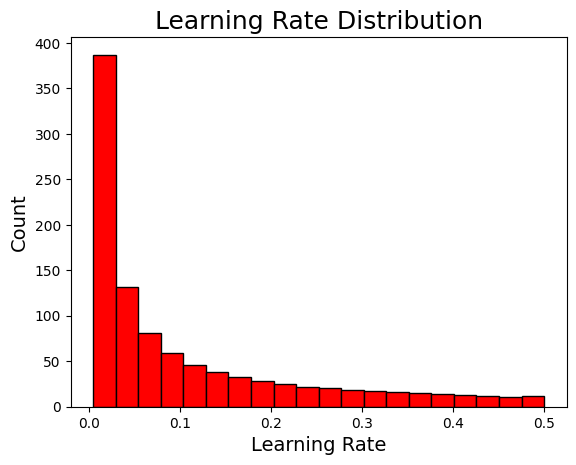

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Learning rate histogram
plt.hist(param_grid['learning_rate'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

In [17]:
a = 0
b = 0

# Check number of values in each category
for x in param_grid['learning_rate']:
    # Check values
    if x >= 0.005 and x < 0.05:
        a += 1
    elif x >= 0.05 and x < 0.5:
        b += 1

print('There are {} values between 0.005 and 0.05'.format(a))
print('There are {} values between 0.05 and 0.5'.format(b))

There are 499 values between 0.005 and 0.05
There are 499 values between 0.05 and 0.5


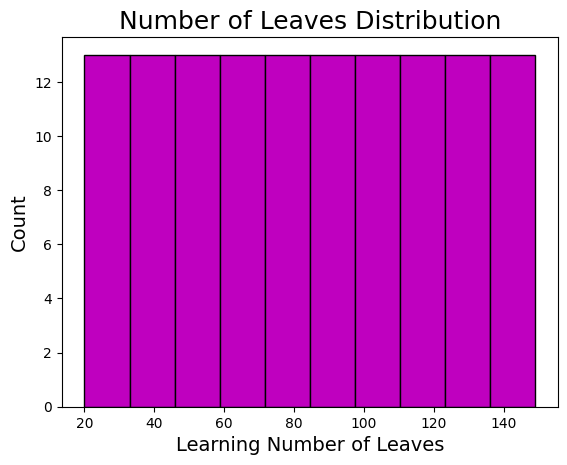

In [18]:
# number of leaves domain
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

### Algorithm

Although we don't generally think of them as such, both grid and random search are algorithms. In the case of grid search, we input the domain and the algorithm selects the next value for each hyperparameter in an ordered sequence. The only requirement of grid search is that it tries every combination in a grid once (and only once). For random search, we input the domain and each time the algorithm gives us a random combination of hyperparameter values to try. There are no requirements for random search other than that the next values are selected at random.

We will implement these algorithms as soon as we cover the final part of hyperparameter tuning.

### Results History

The results history is a data structure that contains the hyperparameter combinations and the resulting score on the objective function.

In [19]:
# Dataframes for random and grid search
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

### Grid Search Implementation

In [20]:
com = 1
for x in param_grid.values():
    com *= len(x)
print('There are {} combinations'.format(com))

There are 2620800000000000 combinations


In [21]:
print('This would take {:.0f} years to finish.'.format((100 * com) / (60 * 60 * 24 * 365)))

This would take 8310502283 years to finish.


In [22]:
import itertools

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""

    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

    keys, values = zip(*param_grid.items())

    i = 0

    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):

        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))

        # Set the subsample ratio accounting for boosting type
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)

        results.loc[i, :] = eval_results

        i += 1

        # Normally would not limit iterations
        if i > MAX_EVALS:
            break

    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)

    return results

In [23]:
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9997
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9997
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Warn

In [24]:
# Get the best parameters
grid_search_params = grid_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**grid_search_params, random_state=42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from grid search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

[LightGBM] [Info] Number of positive: 824, number of negative: 9176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9997
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082400 -> initscore=-2.410176
[LightGBM] [Info] Start training from score -2.410176
The best model from grid search scores 0.73066 ROC AUC on the test set.


### Random Search Implementation

In [25]:
random.seed(50)

# Randomly sample from dictionary
random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
# Deal with subsample ratio
random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

random_params

{'boosting_type': 'goss',
 'num_leaves': 88,
 'learning_rate': 0.027778881111994384,
 'subsample_for_bin': 220000,
 'min_child_samples': 175,
 'reg_alpha': 0.8979591836734693,
 'reg_lambda': 0.6122448979591836,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 1.0,
 'is_unbalance': False}

In [26]:
def random_search(param_grid, max_evals = 1):
    """Random search for hyperparameter optimization"""

    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(1)))

    # Keep searching until reach max evaluations
    for i in range(1):

        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)

        results.loc[i, :] = eval_results

    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results

In [27]:
random_results = random_search(param_grid)

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(random_results.loc[0, 'params'])

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9979
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 84
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9979
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 84
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing 

In [28]:
# Get the best parameters
random_search_params = random_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**random_search_params, random_state = 42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from random search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

[LightGBM] [Info] Number of positive: 824, number of negative: 9176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9979
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082400 -> initscore=-2.410176
[LightGBM] [Info] Start training from score -2.410176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

## Optimization Algorithms

Until now, you have probably always used Gradient Descent to update the parameters and minimize the cost. In this part of the lab, we are going to learn more advanced optimization methods that can speed up learning and perhaps even get you to a better final value for the cost function. Having a good optimization algorithm can be the difference between waiting days vs. just a few hours to get a good result.

To get started, run the following code to import the libraries you will need.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Gradient Descent

A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all
 examples on each step, it is also called Batch Gradient Descent.

Implement the gradient descent update rule. The gradient descent rule is, for l = 1, ..., L

W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}
b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}

where L is the number of layers and \alpha is the learning rate. All parameters should be stored in the parameters dictionary. Note that the iterator l starts at 0 in the for loop while the first parameters are W^{[1]} and b^{[1]}. You need to shift l to l+1 when coding.

###Task 1

In [31]:
# FUNCTION: update_parameters_with_gd

def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent

    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.

    Returns:
    parameters -- python dictionary containing your updated parameters
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(L):

        # ***********************************************
        # TASK 1 - IMPLEMENT GRADIENT DESCENT UPDATE RULE
        # ***********************************************

        # WRITE YOUR CODE HERE
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]  - learning_rate * grads["db" + str(l+1)]

        # ***********************************************
        # ***********************************************

    return parameters

In [32]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()

parameters = update_parameters_with_gd(parameters, grads, learning_rate)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 = [[ 1.74604067]
 [-0.75184921]]
W2 = [[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 = [[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


A variant of this is Stochastic Gradient Descent (SGD), which is equivalent to mini-batch gradient descent where each mini-batch has just 1 example. The update rule that you have just implemented does not change. What changes is that you would be computing gradients on just one training example at a time, rather than on the whole training set. The examples below illustrate the difference between stochastic gradient descent and (batch) gradient descent.

**Batch Gradient Descent**

In [ ]:
# X = data_input
# Y = labels
# parameters = initialize_parameters(layers_dims)
# for i in range(0, num_iterations):
#     # Forward propagation
#     a, caches = forward_propagation(X, parameters)
#     # Compute cost.
#     cost = compute_cost(a, Y)
#     # Backward propagation.
#     grads = backward_propagation(a, caches, parameters)
#     # Update parameters.
#     parameters = update_parameters(parameters, grads)

**Stochastic Gradient Descent**

In [ ]:
# X = data_input
# Y = labels
# parameters = initialize_parameters(layers_dims)
# for i in range(0, num_iterations):
#     for j in range(0, m):
#         # Forward propagation
#         a, caches = forward_propagation(X[:,j], parameters)
#         # Compute cost
#         cost = compute_cost(a, Y[:,j])
#         # Backward propagation
#         grads = backward_propagation(a, caches, parameters)
#         # Update parameters.
#         parameters = update_parameters(parameters, grads)

### Mini-Batch Gradient Descent

First, let us learn how to build mini-batches from the training set (X, Y).

There are 2 steps:

**Shuffle**

Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the i^{th} column of X is the example corresponding to the i^{th} label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches.


**Partition**

Partition the shuffled (X, Y) into mini-batches of size mini_batch_size (here 64). Note that the number of training examples is not always divisible by mini_batch_size. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full mini_batch_size, it will look like this:

Implement random_mini_batches. We coded the shuffling part for you. To help you with the partitioning step, we give you the following code that selects the indexes for the 1^{st} and 2^{nd} mini-batches:


```
first_mini_batch_X = shuffled_X[:, 0 : mini_batch_size]
second_mini_batch_X = shuffled_X[:, mini_batch_size : 2 * mini_batch_size]
```

Note that the last mini-batch might end up smaller than mini_batch_size=64. Let \lfloor s \rfloor represents s rounded down to the nearest integer (this is math.floor(s) in Python). If the total number of examples is not a multiple of mini_batch_size=64 then there will be \lfloor \frac{m}{mini\_batch\_size}\rfloor mini-batches with a full 64 examples, and the number of examples in the final mini-batch will be (m-mini_\_batch_\_size \times \lfloor \frac{m}{mini\_batch\_size}\rfloor).

###Task 2 and 3

In [33]:
# FUNCTION: random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):

        # *******************************
        # TASK 2 - IMPLEMENT PARTITIONING
        # *******************************

        # WRITE YOUR CODE HERE
        mini_batch_X = shuffled_X[:, k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size:(k + 1) * mini_batch_size]

        # *******************************
        # *******************************

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:

        # ************************
        # TASK 3 - HANDLE END CASE
        # ************************

        # WRITE YOUR CODE HERE
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size:]

        # ************************
        # ************************

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [34]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape))
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


### Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations.

Initialize the velocity. The velocity, v, is a python dictionary that needs to be initialized with arrays of zeros. Its keys are the same as those in the grads dictionary, that is: for l =1,...,L:

```
v["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
v["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])
```

###Task 4

In [36]:
# FUNCTION: initialize_velocity

def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL"
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl

    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}

    # Initialize velocity
    for l in range(L):

        # ****************************
        # TASK 4 - INITIALIZE VELOCITY
        # ****************************

        # WRITE YOUR CODE HERE
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape))

        # ****************************
        # ****************************

    return v

In [37]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]


###Task 5

In [38]:
# FUNCTION: update_parameters_with_momentum

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum

    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar

    Returns:
    parameters -- python dictionary containing your updated parameters
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Momentum update for each parameter
    for l in range(L):

        # ************************
        # TASK 5 - MOMENTUM UPDATE
        # ************************

        # WRITE YOUR CODE HERE

        # COMPUTE VELOCITIES
        v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] + (1 - beta) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta * v["db" + str(l+1)] + (1 - beta) * grads["db" + str(l+1)]

        # UPDATE PARAMETERS
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v["db" + str(l+1)]

        # ************************
        # ************************

    return parameters, v

In [39]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

W1 = [[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = [[ 1.74493465]
 [-0.76027113]]
W2 = [[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = [[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]


### Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum.

In [40]:
# FUNCTION: initialize_adam

def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL"
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.

    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl

    Returns:
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """

    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}

    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape))

    return v, s

In [41]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]
s["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = [[0.]
 [0.]]
s["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = [[0.]
 [0.]
 [0.]]


In [42]:
# FUNCTION: update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam

    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates
    beta2 -- Exponential decay hyperparameter for the second moment estimates
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """

    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary

    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads['db' + str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - math.pow(beta1,t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - math.pow(beta1,t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta1 * s["dW" + str(l+1)] + (1 - beta2) * grads['dW' + str(l+1)] * grads['dW' + str(l+1)]
        s["db" + str(l+1)] = beta1 * s["db" + str(l+1)] + (1 - beta2) * grads['db' + str(l+1)] * grads['db' + str(l+1)]

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - math.pow(beta2,t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - math.pow(beta2,t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / (np.square(s_corrected["dW" + str(l+1)])+ epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / (np.square(s_corrected["db" + str(l+1)])+ epsilon)

    return parameters, v, s

In [43]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

W1 = [[ 1.64012005 -0.62577712 -0.55686923]
 [-1.23872803  0.83663988 -2.23573927]]
b1 = [[13.07517618]
 [-0.73554047]]
W2 = [[ 1.41301675e+00 -3.90354632e-01  1.52566920e+00]
 [-1.72338971e+00 -2.57602399e-01 -3.49221843e-01]
 [ 1.20330813e+00  4.05392097e+03 -1.57349972e-01]]
b2 = [[-2.51055757]
 [ 0.03761433]
 [ 0.53134184]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = [[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = [[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = [[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = [[5.49507194e-05]
 [2.75494327e-03]
 [5.50629536e-04]]


##Conclusion of tasks

### **Conclusion of Task-1: Gradient Descent Parameter Update**  

In this task, we implemented the **gradient descent update rule** to adjust the parameters of a neural network.The update is applied iteratively for all layers in the network, ensuring that the model minimizes the loss function. The correctness of the implementation is verified by printing updated parameter values after applying the function. This step is fundamental in optimizing deep learning models using gradient descent.

### **Conclusion of Tasks 2 & 3: Mini-Batch Partitioning for Gradient Descent**

In this task, we implemented the process of **creating random mini-batches** from the given dataset. This is essential for **stochastic gradient descent (SGD) and mini-batch gradient descent**, which improve training efficiency and help avoid local minima.

The mini-batch partitioning follows these steps:

1. **Shuffling the Data:**  
   To ensure randomness in training, the dataset is shuffled using a random permutation.

2. **Creating Complete Mini-Batches:**  
   The dataset is then split into mini-batches of the size 64.

3. **Handling the Last Mini-Batch (if the total samples are not divisible by batch size):**  
   If there are leftover samples that do not fit into a full batch, they are grouped into a smaller final batch.

   This ensures that all training data is utilized effectively.

### **Our understanding:**
1. **Shuffling helps prevent biases in training order.**  
2. **Mini-batching speeds up training compared to full-batch gradient descent.**  
3. **Handling incomplete batches ensures that no data is lost.**  
4. **This method improves model generalization and stability during optimization.**  

By implementing this approach, we create an efficient **mini-batch gradient descent mechanism**, making the training process faster and more robust.


### **Conclusion of Tasks 4 & 5: Parameter Update Using Momentum**  

In this task, we implemented the **momentum-based gradient update**, an optimization technique that accelerates gradient descent by maintaining an exponentially weighted average of past gradients.  

The key steps involved:  

1. **Computing the Velocity:**  
   The velocity update equation smooths out gradient fluctuations, preventing sharp changes. **β** is momentum hyperparameter determines how much past gradients influence the current update.

2. **Updating the Parameters:**  
   The parameters are then updated using the momentum-adjusted gradients

   

    

### **Our understanding:**  
1. **Momentum reduces oscillations** in gradient descent, leading to faster convergence.  
2. **Smooths updates** by incorporating past gradient information, making training more stable.  
3. **Particularly effective in deep networks** where standard gradient descent might be slow.  

By implementing momentum-based optimization, we enhance **gradient descent efficiency**, making learning faster and more reliable.
